<a href="https://colab.research.google.com/github/varunk04/computer_vision/blob/main/07_transfer_learning(scaling_up).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning part 3: Scaling Up.

In [1]:
# COnnecting to GPU:

!nvidia-smi

Sat Jun 10 14:29:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Downloading the resources/data:

In [2]:
# Downloading the helper functions:
!wget https://raw.githubusercontent.com/varunk04/Helper_functions/main/helper_functions.py

--2023-06-10 14:29:18--  https://raw.githubusercontent.com/varunk04/Helper_functions/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-10 14:29:18 (109 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper function:
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir,compare_historys

In [4]:
# Downlaod the data:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

# unziping the data:
unzip_data('101_food_classes_10_percent.zip')

#Setting up training ands testing directories:
train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

--2023-06-10 14:29:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   226MB/s    in 6.9s    

2023-06-10 14:29:29 (224 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



Data now we are working with is 10% of the orginal food101 data, which has 101 classes of the food, each with 750 images.

In [5]:
# lets check the directories:

walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/prime_rib'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cannoli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/omelette'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_quesadilla'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/carrot_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheesecake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/takoyaki'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/dumplings'.
There are 0 directories and 250 images in '101_food

In [6]:
# Setup data inputs:
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_10 = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                    label_mode = 'categorical',
                                                                    image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Training the model with transfer learning on 10% of 101 food classes:

Steps:

* Set up model checkpoint callback
* Create a data augmentation layer
* Build a headless(no top layers) Functional EfficientNetB0 model.
* Compile the modle.
* Feature Extract for 5 full passes (validate on 15% test data)

In [7]:
# Create checkpoint callback:

checkpoint_path = '101_classes_10%_data_model_checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor= 'val_accuracy',
                                                         save_best_only = True)

In [8]:
# creating a data augmentation layer:

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Set-up the data augmentation:

data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name = 'data_augmentation')

In [9]:
# Set-up the base model and freeze its layers(Feature Extraction):

base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

# Set-up model archetecture with trainable top layers.

inputs = layers.Input(shape = (224,224,3), name = 'Input_layer')
x = data_augmentation(inputs)
x= base_model(x, training = False)
x= layers.GlobalAveragePooling2D(name = 'global_avg_pooling_layer')(x)
outputs = layers.Dense(len(train_data_10.class_names), activation = 'softmax', name = 'Output_layer')(x)

#creating the model:

model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [10]:
# Getting model summary:

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 Output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [11]:
# compiling the model:

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

# Fit the model:
history_1 = model.fit(train_data_10,
                      epochs = 5,
                      validation_data = test_data,
                      validation_steps = int(0.15*len(test_data)),
                      callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 113s 409ms/step - loss: 3.3749 - accuracy: 0.2729 - val_loss: 2.5141 - val_accuracy: 0.4513
Epoch 2/5
237/237 [==============================] - 74s 310ms/step - loss: 2.2000 - accuracy: 0.4964 - val_loss: 2.1110 - val_accuracy: 0.4865
Epoch 3/5
237/237 [==============================] - 65s 270ms/step - loss: 1.8225 - accuracy: 0.5665 - val_loss: 1.9251 - val_accuracy: 0.5209
Epoch 4/5
237/237 [==============================] - 57s 241ms/step - loss: 1.6047 - accuracy: 0.6077 - val_loss: 1.8338 - val_accuracy: 0.5273
Epoch 5/5
237/237 [==============================] - 57s 241ms/step - loss: 1.4440 - accuracy: 0.6448 - val_loss: 1.7897 - val_accuracy: 0.5302


In [12]:
# Lets evsluate the nodel with whole test data;

fine_tunning_results = model.evaluate(test_data)

790/790 [==============================] - 61s 77ms/step - loss: 1.5857 - accuracy: 0.5844


In [13]:
fine_tunning_results

[1.585711121559143, 0.5844356417655945]

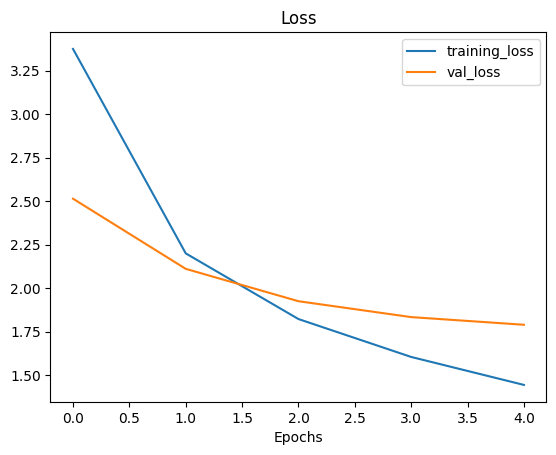

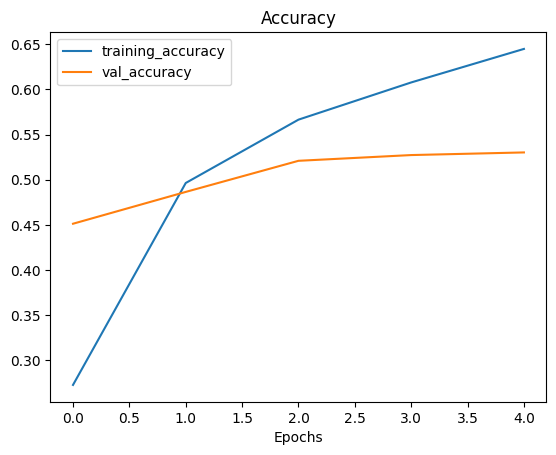

In [14]:
# Lets plot the loss curves:

plot_loss_curves(history_1)

With just 10% of data and with the help of transfer we were able to achive the accuracy of 58%, which is higher than what was achived by the paper taht published the Food101 data.

## Fine-tunning:

In [15]:
# Ubfreeze all of the layers in the base model:

base_model.trainable = True

# Refreeze every layer except the last 5:
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [16]:
# Recompile the model with lower learning rate:

model.compile(
    loss= 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
    metrics = ['accuracy']
)

In [17]:
# Lets check what layers in the model are trainabel:
for layer in model.layers:
  print(layer.name, layer.trainable)

Input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pooling_layer True
Output_layer True


In [18]:
# Checking which layers are trainable in our base model:
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [19]:
# Fine tune for 5 more epochs:

fine_tune_epochs = 10 # Model has already done 5 epochs(feature extraction), so this is total number of epochs.

# Fine tune our model:
history_2 = model.fit(train_data_10,
                      epochs = fine_tune_epochs,
                      validation_data = test_data,
                      validation_steps = int(0.15*len(test_data)),
                      initial_epoch = history_1.epoch[-1]
                      )

Epoch 5/10
237/237 [==============================] - 67s 240ms/step - loss: 1.2115 - accuracy: 0.6917 - val_loss: 1.7469 - val_accuracy: 0.5376
Epoch 6/10
237/237 [==============================] - 53s 221ms/step - loss: 1.0888 - accuracy: 0.7130 - val_loss: 1.7156 - val_accuracy: 0.5506
Epoch 7/10
237/237 [==============================] - 53s 223ms/step - loss: 1.0196 - accuracy: 0.7315 - val_loss: 1.7439 - val_accuracy: 0.5410
Epoch 8/10
237/237 [==============================] - 47s 198ms/step - loss: 0.9627 - accuracy: 0.7420 - val_loss: 1.7449 - val_accuracy: 0.5429
Epoch 9/10
237/237 [==============================] - 48s 202ms/step - loss: 0.8869 - accuracy: 0.7630 - val_loss: 1.7718 - val_accuracy: 0.5350
Epoch 10/10
237/237 [==============================] - 46s 191ms/step - loss: 0.8488 - accuracy: 0.7690 - val_loss: 1.7920 - val_accuracy: 0.5347


In [20]:
 # Lets evaluate it on the whole test set:
fine_tune_results_2 =  model.evaluate(test_data)

790/790 [==============================] - 67s 85ms/step - loss: 1.5126 - accuracy: 0.6009


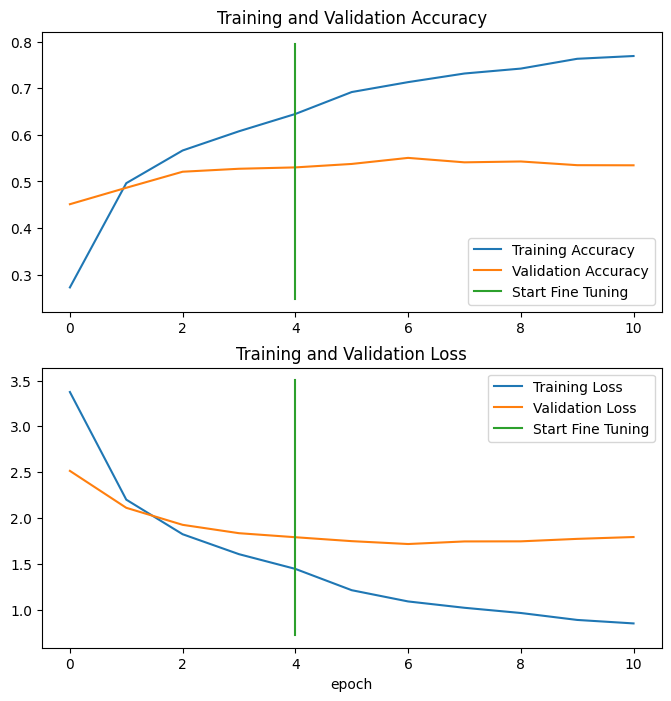

In [21]:
# Lets compare the histories of two models and lets check if unfreezing the last 5 layers has improved our model or not:
compare_historys(original_history=history_1,
                 new_history = history_2,
                 initial_epochs = 5)

From the graphs following points can be noted:
* Train acuracy and loss is decreasing.
* But test acuurcaty remain same even after fine tunning the base model.
* Indicating there is overfitting in the model.

## Saving and Loading our model:
 To use our model in extrenal application, we'll need to save it and export it somewhere.

In [22]:
# Save our fine-tune model in google drive:
model.save('drive/MyDrive/tesnorflow_models/10%_101_food_class_fine_tunned_model.keras', save_format='keras_v3')

In [23]:
# Load the model:
loaded_model = tf.keras.saving.load_model('drive/MyDrive/tesnorflow_models/10%_101_food_class_fine_tunned_model.keras')

TypeError: ignored

In [24]:
model.evaluate(test_data)

790/790 [==============================] - 62s 79ms/step - loss: 1.5126 - accuracy: 0.6009


[1.5125954151153564, 0.6008712649345398]

## Making predictions with our trained Model:

In [25]:
# Make predictions with model:
preds_probs = model.predict(test_data, verbose =1) # Set verbosity to see how long is left

790/790 [==============================] - 69s 86ms/step


In [26]:
# How many predictions are there:

len(preds_probs)

25250

In [27]:
# Whats the shape of our predictions:
preds_probs.shape

(25250, 101)

So we have 25250 images, each imgae with 101 probablity values each value corresponds to each class.

In [28]:
# Lets examine the first 10 predictions:
preds_probs[:10]

array([[2.4438220e-01, 9.1387948e-05, 1.1423288e-01, ..., 2.5270736e-05,
        3.5363405e-03, 5.6330683e-03],
       [9.6237665e-01, 1.6845124e-08, 3.3092790e-04, ..., 1.6214160e-03,
        1.0861960e-07, 1.8380305e-06],
       [5.5373591e-01, 1.6434614e-02, 6.9019636e-03, ..., 4.0821184e-04,
        3.6255209e-04, 1.2741903e-03],
       ...,
       [3.5275429e-01, 1.3611787e-05, 1.2786530e-03, ..., 4.5798570e-02,
        8.0799096e-04, 1.7279324e-04],
       [1.6898414e-01, 2.8391028e-04, 1.5746908e-01, ..., 1.8400018e-04,
        1.6501670e-04, 5.0499344e-05],
       [6.5533221e-01, 4.5629727e-07, 1.1771272e-03, ..., 3.4270897e-03,
        1.5158113e-06, 2.7642451e-04]], dtype=float32)

In [29]:
preds_probs[0]

array([2.4438220e-01, 9.1387948e-05, 1.1423288e-01, 6.2714001e-08,
       4.0529035e-06, 5.3723051e-07, 4.6321489e-05, 1.4775297e-06,
       3.4142166e-02, 1.9538087e-04, 3.1554271e-07, 4.0758960e-06,
       9.1693731e-04, 7.4827170e-07, 6.3909120e-03, 1.2515894e-03,
       8.3326568e-06, 7.3980243e-04, 3.8934557e-03, 1.2116338e-05,
       4.3641354e-04, 6.9554794e-06, 1.3310673e-04, 4.3945147e-05,
       7.6192775e-04, 1.6712840e-03, 9.6108229e-04, 3.5994588e-05,
       1.3542074e-01, 6.1124779e-04, 3.6576537e-06, 9.6471858e-04,
       4.6123166e-04, 1.1579095e-06, 8.8415314e-03, 2.7471215e-06,
       9.7536773e-05, 8.8505697e-04, 7.2666362e-02, 7.1581599e-05,
       5.8750110e-04, 4.0795947e-03, 3.6456343e-04, 7.9096772e-06,
       4.7290087e-05, 2.5159108e-05, 1.3719997e-03, 1.7691770e-04,
       3.8437456e-06, 5.9480239e-02, 1.9042417e-04, 3.2873617e-05,
       8.8649556e-02, 9.3161993e-02, 1.8072446e-05, 6.7995549e-03,
       1.9942444e-02, 3.0781243e-03, 5.9135365e-03, 2.9903180e

In [30]:
tf.argmax(preds_probs[0])

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [31]:
# lets check which class this value belongs to :
test_data.class_names[tf.argmax(preds_probs[0])]

'apple_pie'

In [32]:
# get the pred classes of each label:
pred_classes = preds_probs.argmax(axis = 1)

# How do they look like?
pred_classes[:10]

array([ 0,  0,  0,  8,  8, 78, 29,  0,  8,  0])

In [33]:
# Lets check how many values are there in the pred_classes:
len(pred_classes)

25250

Awesome there are 25250 images in test set and there are same number of prediction classes.

In [34]:
# To get our test lables we have to unravel the test set:
y_labels = []

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
  # Curently test lables look like: [0,0,0,1...], we want index value of 1 hence we use argmax()

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluating model predictions:

In [35]:
# Lest use the sklearns metrics api:

from sklearn.metrics import accuracy_score

sk_sccuracy = accuracy_score(y_true = y_labels,
                             y_pred = pred_classes)
sk_sccuracy

0.6008712871287128

In [36]:
fine_tune_results_2

[1.5125954151153564, 0.6008712649345398]

This is very close to our fine tuned mode, evaluation results.

In [37]:
import numpy as np

np.isclose(fine_tune_results_2[1],sk_sccuracy)

True

## Lets get visual making confusion matrix:

We have developed a function whihc contains the code to plot the confusion matrix.

Lets use that to plot the confusion matrix for 101 classes of food

In [38]:
from helper_functions import make_confusion_matrix

In [39]:
make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = test_data.class_names,
                      figsize = (100,100),
                      text_size = 20)

## Lets evaluate some other metrics using scikit learn:

In [40]:
from sklearn.metrics import classification_report

print(classification_report(y_true = y_labels,
                            y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.35      0.18      0.23       250
           1       0.58      0.68      0.62       250
           2       0.72      0.58      0.65       250
           3       0.90      0.46      0.61       250
           4       0.63      0.34      0.44       250
           5       0.49      0.40      0.44       250
           6       0.77      0.77      0.77       250
           7       0.89      0.72      0.80       250
           8       0.20      0.64      0.31       250
           9       0.47      0.62      0.53       250
          10       0.59      0.43      0.50       250
          11       0.85      0.52      0.65       250
          12       0.71      0.64      0.67       250
          13       0.56      0.55      0.55       250
          14       0.66      0.49      0.56       250
          15       0.38      0.44      0.40       250
          16       0.71      0.52      0.60       250
          17       0.34    

In [41]:
# Get a dictionary of classification report

classification_report_dict = classification_report(y_labels, pred_classes, output_dict = True)

In [42]:
classification_report_dict

{'0': {'precision': 0.3492063492063492,
  'recall': 0.176,
  'f1-score': 0.2340425531914893,
  'support': 250},
 '1': {'precision': 0.5782312925170068,
  'recall': 0.68,
  'f1-score': 0.625,
  'support': 250},
 '2': {'precision': 0.7227722772277227,
  'recall': 0.584,
  'f1-score': 0.6460176991150444,
  'support': 250},
 '3': {'precision': 0.8984375,
  'recall': 0.46,
  'f1-score': 0.6084656084656086,
  'support': 250},
 '4': {'precision': 0.6296296296296297,
  'recall': 0.34,
  'f1-score': 0.4415584415584416,
  'support': 250},
 '5': {'precision': 0.4854368932038835,
  'recall': 0.4,
  'f1-score': 0.4385964912280702,
  'support': 250},
 '6': {'precision': 0.768, 'recall': 0.768, 'f1-score': 0.768, 'support': 250},
 '7': {'precision': 0.8916256157635468,
  'recall': 0.724,
  'f1-score': 0.7991169977924943,
  'support': 250},
 '8': {'precision': 0.20175438596491227,
  'recall': 0.644,
  'f1-score': 0.30725190839694655,
  'support': 250},
 '9': {'precision': 0.46567164179104475,
  'recal

In [43]:
class_names  = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

Lets plot all of our classes F1-scores

In [44]:
# Create empty dictionary:

class_f1_scores = {}

# Loop through classification report dictionary items:

for k,v in classification_report_dict.items():
  if k == 'accuracy':
    break
  else:
    # Add class names and f1 scores to new dictionary:
    class_f1_scores[class_names[int(k)]] = v['f1-score']

class_f1_scores

{'apple_pie': 0.2340425531914893,
 'baby_back_ribs': 0.625,
 'baklava': 0.6460176991150444,
 'beef_carpaccio': 0.6084656084656086,
 'beef_tartare': 0.4415584415584416,
 'beet_salad': 0.4385964912280702,
 'beignets': 0.768,
 'bibimbap': 0.7991169977924943,
 'bread_pudding': 0.30725190839694655,
 'breakfast_burrito': 0.5333333333333333,
 'bruschetta': 0.5,
 'caesar_salad': 0.6469135802469137,
 'cannoli': 0.6708860759493671,
 'caprese_salad': 0.5542168674698795,
 'carrot_cake': 0.5596330275229359,
 'ceviche': 0.40445269016697594,
 'cheese_plate': 0.6018518518518517,
 'cheesecake': 0.42137404580152665,
 'chicken_curry': 0.5193370165745856,
 'chicken_quesadilla': 0.6511627906976745,
 'chicken_wings': 0.6859344894026976,
 'chocolate_cake': 0.5461847389558232,
 'chocolate_mousse': 0.3711711711711712,
 'churros': 0.7264770240700219,
 'clam_chowder': 0.7313131313131312,
 'club_sandwich': 0.72,
 'crab_cakes': 0.4074074074074074,
 'creme_brulee': 0.7711340206185568,
 'croque_madame': 0.6823529411

In [47]:
# Turn f1 scores into dataframes for visulization:

import pandas as pd
f1_scores = pd.DataFrame({'class_names':list(class_f1_scores.keys()),
                         'f1-score':list(class_f1_scores.values())}).sort_values('f1-score', ascending=False)
f1_scores[:10]

,class_names,f1-score
33,edamame,0.968254
63,macarons,0.897704
69,oysters,0.870103
32,dumplings,0.843373
45,frozen_yogurt,0.837500
86,sashimi,0.833333
65,mussels,0.828753
75,pho,0.821168
54,hot_and_sour_soup,0.812632
68,onion_rings,0.805243


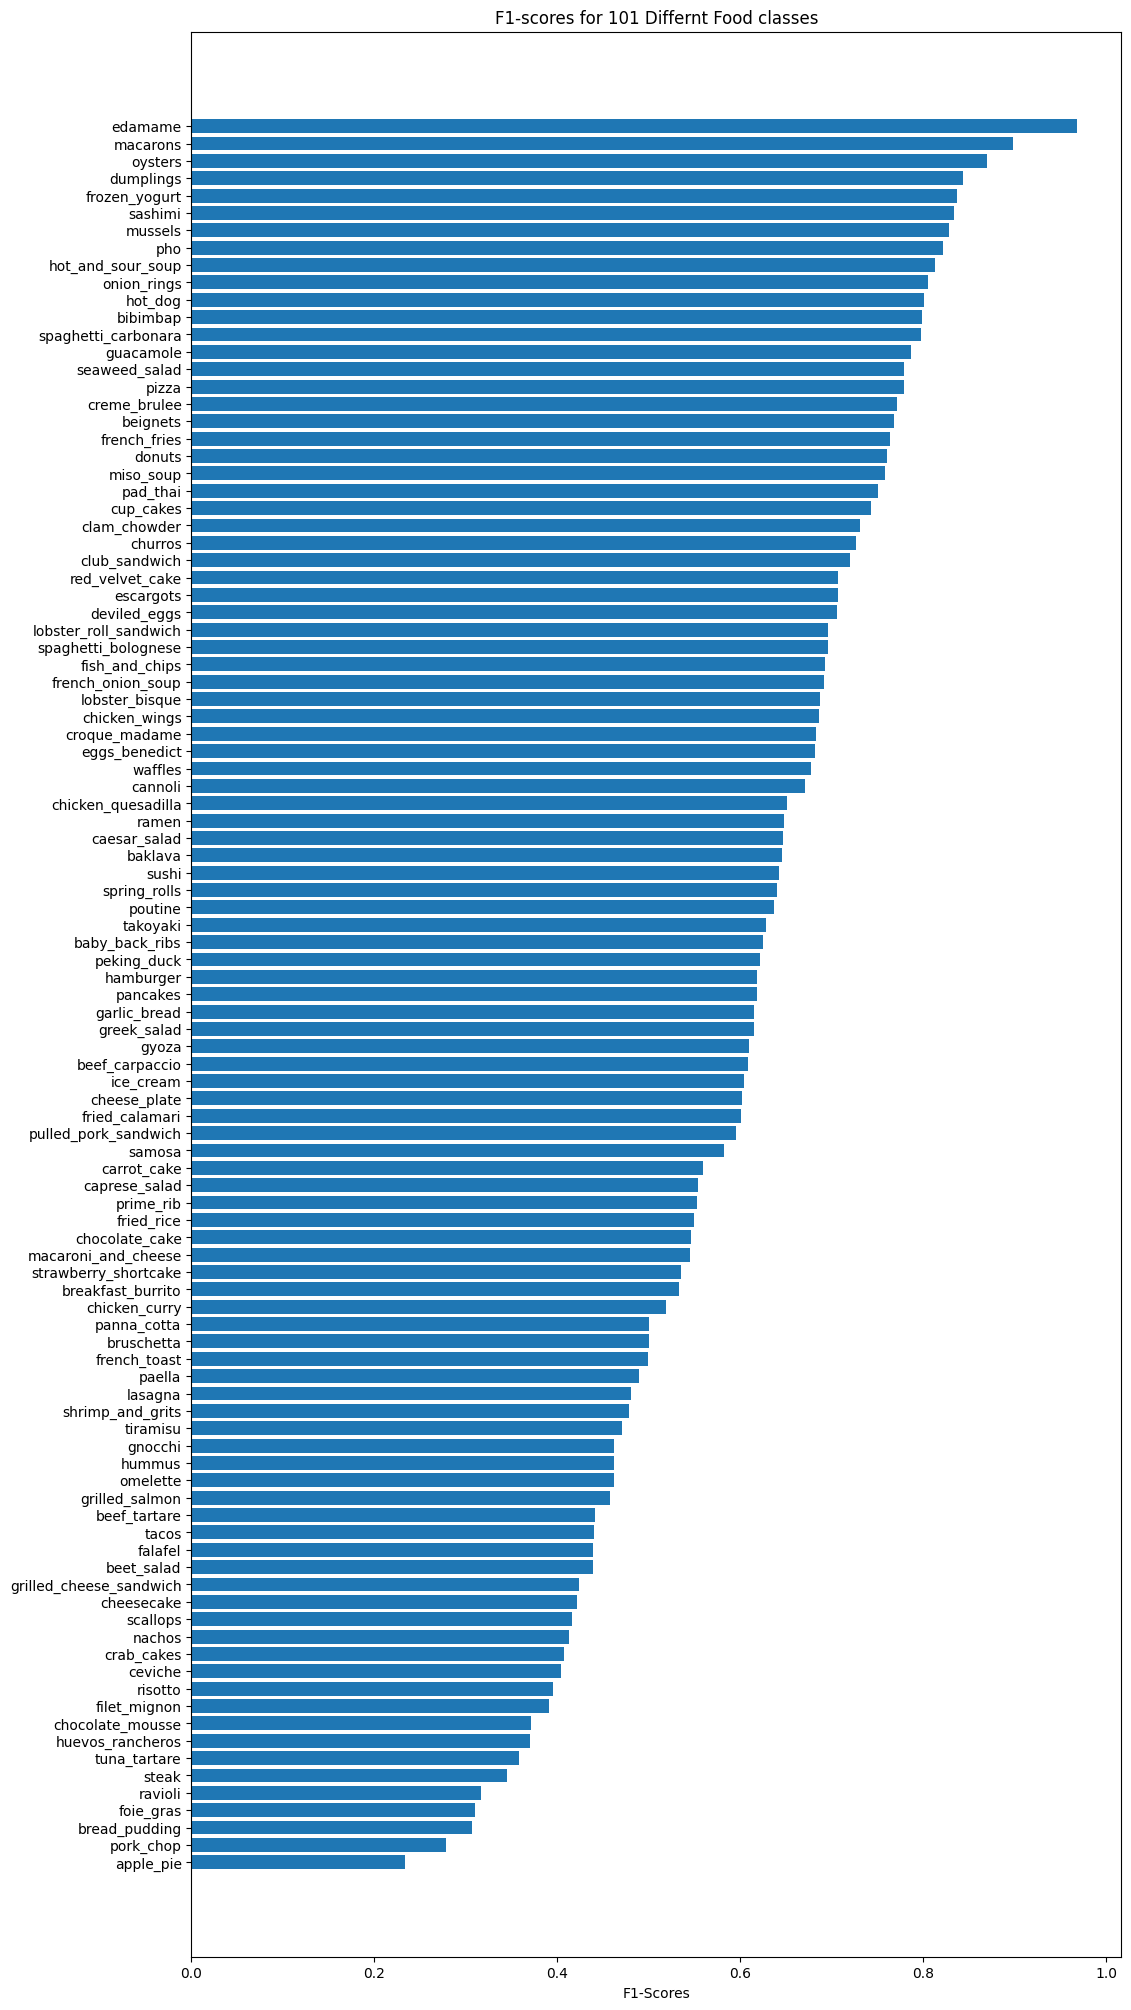

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12,25))

scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names']);
ax.set_xlabel('F1-Scores')
ax.set_title('F1-scores for 101 Differnt Food classes')
ax.invert_yaxis();

**Thats the f1-score for each class as predicted by our model.**